In [5]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib as mpl
# use precise epoch
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

data_dir = '/home/mnedal/data'
# data_dir = '/home/mnedal/data/nenufar_data' # on the DIAS-lofar machine
mydate = '2025-03-26'

In [6]:
year, month, day = mydate.split('-')

In [7]:
# files = glob.glob(f'{data_dir}/NDA_{day}{month}{year}_*.fits')

files = glob.glob(f'{data_dir}/int_orf{year}{month}{day}_*.fts')

orfees_data = pyfits.open(files[0])
orfees_data.info()

Filename: /home/mnedal/data/int_orf20250326_050200_0.1.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  FREQUENCIES    1 BinTableHDU     37   1R x 11C   [1J, 1J, 431E, 1J, 215E, 1J, 164E, 1J, 86E, 1J, 102E]   
  2  SPECTRA       1 BinTableHDU     78   329194R x 15C   [1J, 431E, 431E, 1J, 215E, 215E, 1J, 164E, 164E, 1J, 86E, 86E, 1J, 102E, 102E]   


In [8]:
orfees_data[2].header['BUNIT']

'SFU/PIXEL'

In [10]:
# define x and y axes
orfees_freq = pd.DataFrame(orfees_data[3].data).values.reshape(-1)
orfees_time = pd.DataFrame(orfees_data[4].data).values.reshape(-1)

orfees_arr1 = orfees_data[1].data
orfees_arr2 = orfees_data[2].data

orfees_arr1 = 10 * np.log10(orfees_arr1) # Convert the amplitude to decibels
orfees_arr2 = 10 * np.log10(orfees_arr2) # Convert the amplitude to decibels

datetime_obj_start = orfees_data[0].header['DATE-OBS'] + ' ' + orfees_data[0].header['TIME-OBS']
datetime_obj_end   = orfees_data[0].header['DATE-OBS'] + ' ' + orfees_data[0].header['TIME-END']

start_obs_time = datetime.strptime(datetime_obj_start, '%d/%m/%Y %H:%M:%S')
end_obs_time   = datetime.strptime(datetime_obj_end, '%d/%m/%Y %H:%M:%S')

time_in_seconds = orfees_data[4].data['time_in_seconds']
times = [start_obs_time + timedelta(seconds=ts) for ts in time_in_seconds]

IndexError: list index out of range

In [5]:
if len(times) < orfees_arr1.shape[1]:
    # num of missed time steps
    n_miss = [orfees_arr1.shape[1] - len(times)]
    dt = np.diff(time_in_seconds)[-1] # time cadence
    for n in n_miss:
        times.append(times[-1] + timedelta(seconds=dt))

assert len(times) == orfees_arr1.shape[1], 'Length of time axis does not match the data array x-dim'

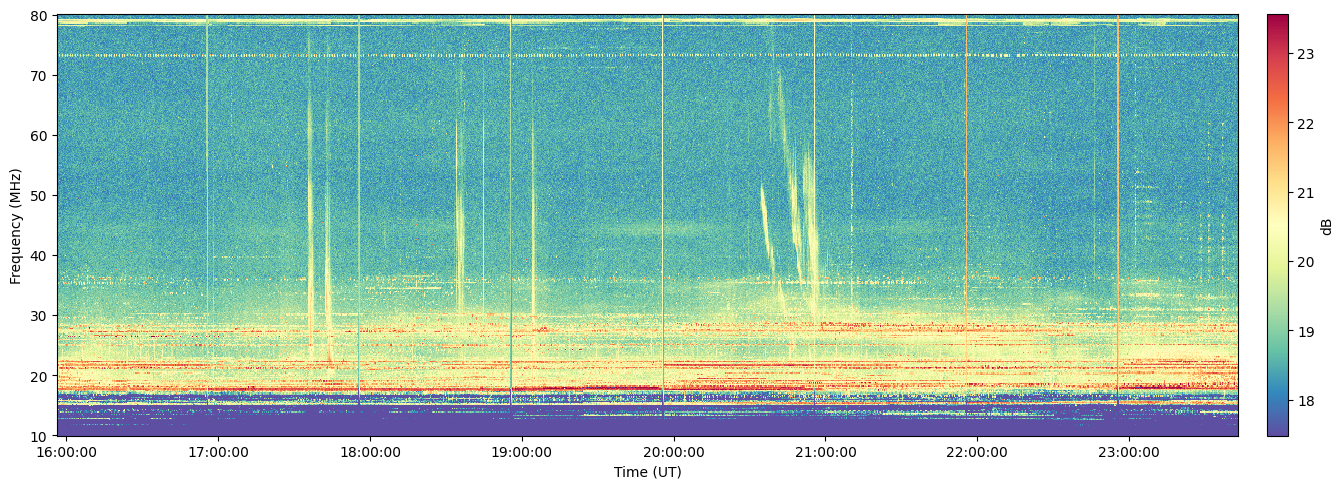

In [6]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(times, orfees_freq, orfees_arr1,
                   vmin=np.nanpercentile(orfees_arr1, 7),
                   vmax=np.nanpercentile(orfees_arr1, 99.97),
                   shading='nearest', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

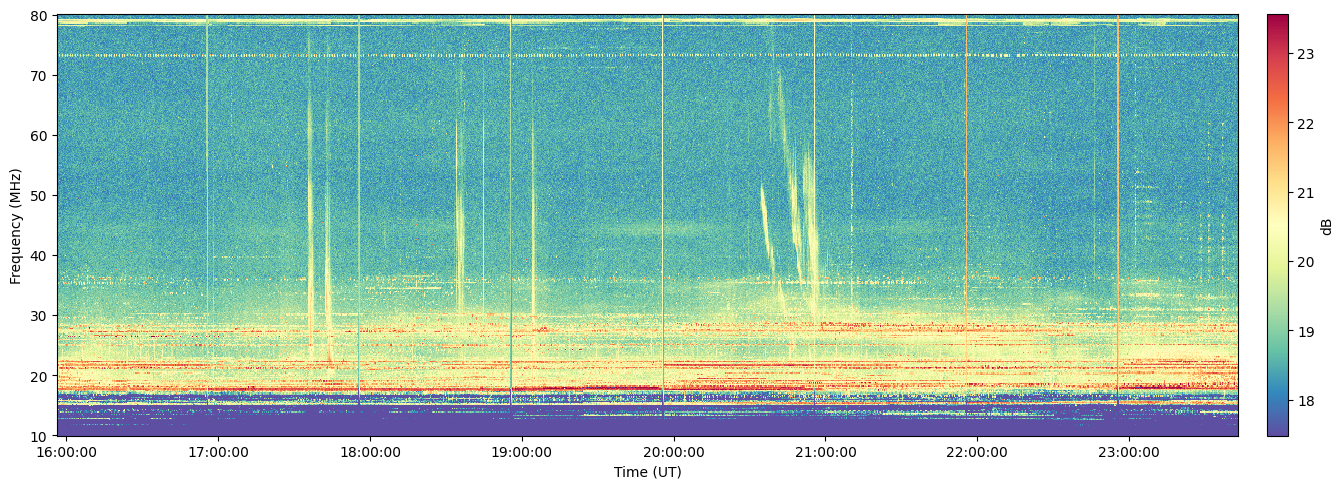

In [8]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(times, orfees_freq, orfees_arr2,
                   vmin=np.nanpercentile(orfees_arr2, 7),
                   vmax=np.nanpercentile(orfees_arr2, 99.97),
                   shading='nearest', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

### From Shilpi
#### originally prepared by Shane Maloney and Pearse Murphy

In [24]:
#### Plot ORFEES spectra
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import time, os, pdb
import time, os
from matplotlib import dates
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
# import argparse
from datetime import datetime
from matplotlib import dates
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
from astropy.io import fits
import astropy.units as u
from sunpy.net import Fido, attrs as a
from astropy.time import Time
from matplotlib.colors import LogNorm
# from radiospectra.spectrogram2 import Spectrogram

In [13]:
orfees = fits.open(files[0])
print(*orfees, sep='\n')

In [14]:
orfees.info()

Filename: /home/mnedal/data/int_orf20250326_050200_0.1.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  FREQUENCIES    1 BinTableHDU     37   1R x 11C   [1J, 1J, 431E, 1J, 215E, 1J, 164E, 1J, 86E, 1J, 102E]   
  2  SPECTRA       1 BinTableHDU     78   329194R x 15C   [1J, 431E, 431E, 1J, 215E, 215E, 1J, 164E, 164E, 1J, 86E, 86E, 1J, 102E, 102E]   


In [15]:
orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
orfees_i.shape

(998, 329194)

In [16]:
data = orfees_i.T
data.shape

(329194, 998)

1. What is the purpose of this loop?
```python
for i in range(data.shape[0]):
	data[i] = data[i]/data[-1]
```

2. What is the unit of the time values in this array? ms?
```python
orfees[2].data['TIME_B1']
```

3. Why the times are not prepared like this?
```python
np.hstack([Time(orfees_time_str) + (orfees[2].data[f'TIME_B{i}']/1000)*u.s for i in range(1, 6)])
```

In [17]:
orfees_time_str = orfees[0].header['DATE-OBS']
orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)])*u.MHz

In [50]:
# # Remove the background by taking the data from the quiet background and divide it by the data
# for i in range(data.shape[0]):
# 	data[i] = data[i]/data[35000]

In [18]:
orfees_times.shape, orfees_freqs.reshape(-1).shape, data.shape

((329194,), (998,), (329194, 998))

In [19]:
df = pd.DataFrame(data=data, index=orfees_times, columns=orfees_freqs.value.reshape(-1))
df.index.name   = 'Time'
df.columns.name = 'Frequency'
df.head()

Frequency,144.130005,144.520004,144.910004,145.300003,145.690002,146.960007,148.089996,148.429993,148.820007,149.210007,...,990.729980,992.289978,993.859985,995.419983,996.979980,998.539978,1000.109985,1001.669983,1003.229980,1004.700012
Time,,,,,,,,,,,,,,,,,,,,,
2025-03-26 07:46:43.580,41.720001,50.66,57.477501,54.875,56.982502,56.875,55.130001,55.315002,54.660000,55.592503,...,41.669376,40.091873,46.627499,39.463123,39.887505,47.371876,44.288128,49.587498,53.906246,68.492859
2025-03-26 07:46:43.680,41.720001,50.66,55.987503,54.875,58.485001,55.250,53.639999,55.315002,55.032501,54.110001,...,41.669376,39.203125,46.137501,41.395000,39.887505,47.371876,45.543751,47.918751,53.906246,68.492859
2025-03-26 07:46:43.780,41.720001,50.66,55.987503,54.875,57.082500,54.430,54.633335,54.195000,55.029999,55.592499,...,42.108749,38.285000,45.644375,40.434372,40.853127,46.748123,46.193752,48.718746,53.906246,68.557144
2025-03-26 07:46:43.880,41.720001,50.66,57.477501,54.875,56.305000,56.055,52.646667,55.315002,55.407501,54.852501,...,40.360001,40.994999,46.137501,40.906246,39.887505,46.748123,44.288128,48.712498,53.906246,68.492859
2025-03-26 07:46:43.980,41.720001,50.66,56.272503,54.875,56.305000,55.250,54.136669,55.312500,55.407501,55.222500,...,40.795628,36.926250,45.647503,39.952496,40.367504,45.524376,44.938126,47.862499,53.906246,68.492859


In [20]:
df.index = [t.datetime for t in df.index]

In [21]:
# downsample to 1s
df_orfees_1s = df.resample('1S').mean()

In [38]:
# remove const bkg
df_orfees_1s_nobkg = df_orfees_1s - np.tile(np.median(df_orfees_1s,0), (df_orfees_1s.shape[0],1))

In [48]:
np.nanpercentile(df_orfees_1s_nobkg, 97.5)

np.float32(85.46124)

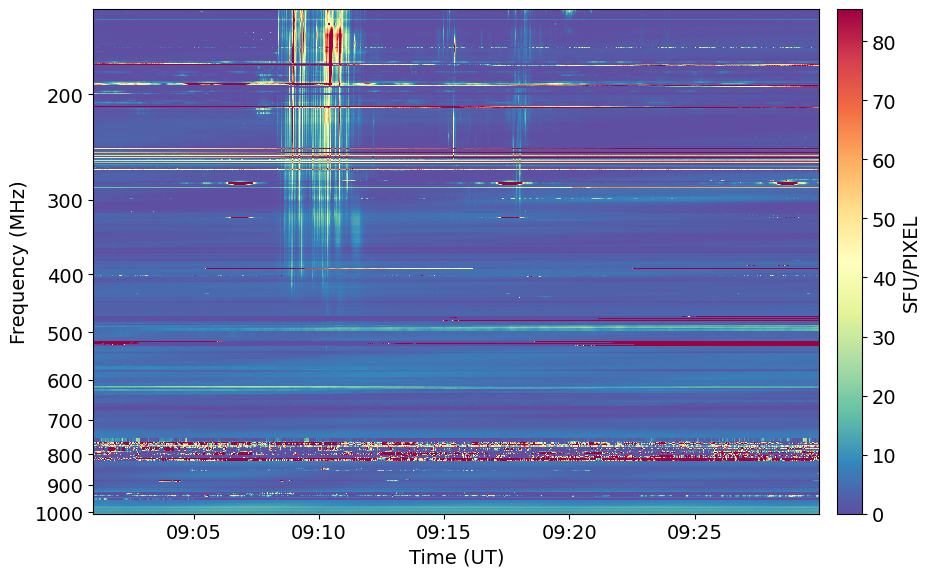

In [51]:
# start_time = '2025-03-25T12:21:00'
# end_time   = '2025-03-25T13:12:00'

start_time = '2025-03-26T09:01:00'
end_time   = '2025-03-26T09:29:59'

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s_nobkg.index, df_orfees_1s_nobkg.columns, df_orfees_1s_nobkg.T,
                   # vmin=0,
                   # norm=LogNorm(vmin=1e1, vmax=1e2),
                   vmin=np.nanpercentile(df_orfees_1s_nobkg, 50),
                   vmax=np.nanpercentile(df_orfees_1s_nobkg, 97.5),
                   # shading='nearest',
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees_data[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
custom_ticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(custom_ticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp(start_time), right=pd.Timestamp(end_time))
fig.tight_layout()
plt.show()

In [52]:
# start_time = '2025-03-26T09:00:00'
# end_time   = '2025-03-26T09:30:00'

# fig = plt.figure(figsize=[10,6])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
#                    vmin=np.nanpercentile(df_orfees_1s, 50),
#                    vmax=np.nanpercentile(df_orfees_1s, 97.5),
#                    cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees_data[2].header['BUNIT'])
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
# custom_ticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(custom_ticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_xlim(left=pd.Timestamp(start_time), right=pd.Timestamp(end_time))
# fig.tight_layout()
# plt.show()

In [28]:
# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
#                    vmin=np.nanpercentile(df_orfees_1s, 1),
#                    vmax=np.nanpercentile(df_orfees_1s, 96),
#                    shading='nearest', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees_data[2].header['BUNIT'])
# # ax.set_yscale('log')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [31]:
# Remove constant background
df_new = df_orfees_1s - np.tile(np.mean(df_orfees_1s,0), (df_orfees_1s.shape[0],1))

In [32]:
# fig = plt.figure(figsize=[10,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_new.index, df_new.columns, df_new.T,
#                    # vmin=np.nanpercentile(df_new, 1),
#                    # vmax=np.nanpercentile(df_new, 96),
#                    # norm=LogNorm(vmin=np.nanpercentile(df_new, 1), vmax=np.nanpercentile(df_new, 96)),
#                    # norm=LogNorm(),
#                    shading='nearest', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

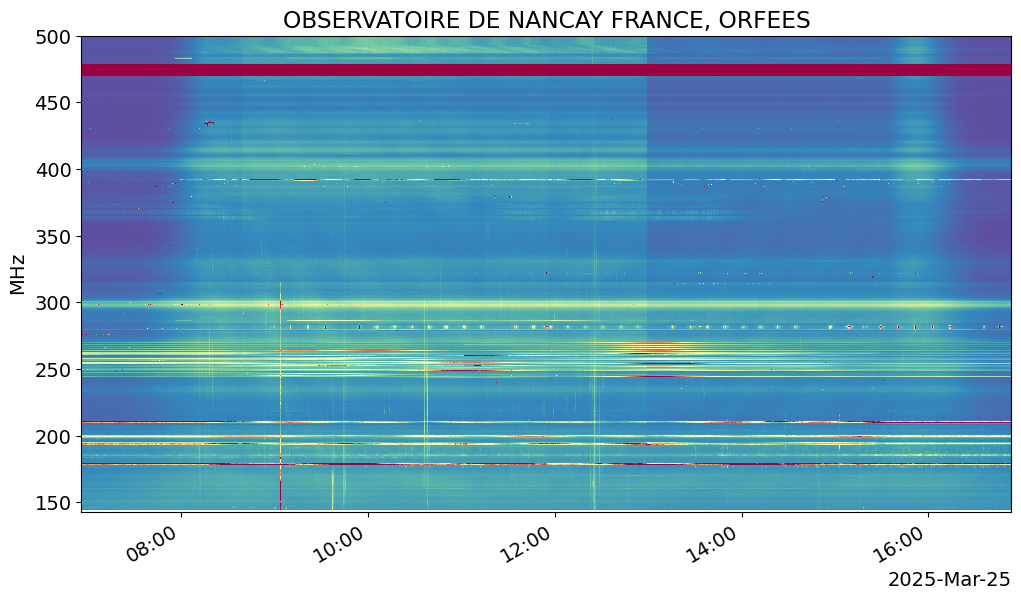

In [6]:
import matplotlib.ticker as ticker
import argparse
from datetime import datetime
from matplotlib import dates
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
from astropy.io import fits
import astropy.units as u
from sunpy.net import Fido, attrs as a
from astropy.time import Time
from matplotlib.colors import LogNorm
from radiospectra.spectrogram2 import Spectrogram

# orfees = fits.open('/Users/shilpibhunia/Documents/event_2025_03_25/data/int_orf20250325_122000_0.1.fts')
orfees = fits.open(files[0])

orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
data = orfees_i.T

# Remove the background by taking the data from the quiet background and divide it by the data
#for i in range(data.shape[0]):
#	data[i] = data[i]/data[35000]

data = data.T
#pdb.set_trace()

orfees_time_str = orfees[0].header['DATE-OBS']
orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)]) *u.MHz

orfees_meta = {
    'observatory': orfees[0].header['ORIGIN'],
    'instrument': orfees[0].header['INSTRUME'],
    'detector': orfees[0].header['INSTRUME'],
    'freqs': orfees_freqs.reshape(-1),
    'times': orfees_times,
    'wavelength': a.Wavelength(orfees_freqs[0,0], orfees_freqs[0,-1]),
    'start_time': orfees_times[0],
    'end_time': orfees_times[-1]
}

###### Plot the spec
orfees_spec_i = Spectrogram(data, orfees_meta)
#pdb.set_trace()
vmm = np.percentile(orfees_spec_i.data, [1,96])
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
#orfees_spec_i.plot(axes = ax, norm=LogNorm(vmin=vmm[0], vmax=vmm[1]), cmap = 'Spectral_r')
orfees_spec_i.plot(axes = ax, vmin=vmm[0], vmax=vmm[1], cmap = 'Spectral_r')
ax.set_ylim(143,500)
plt.show()

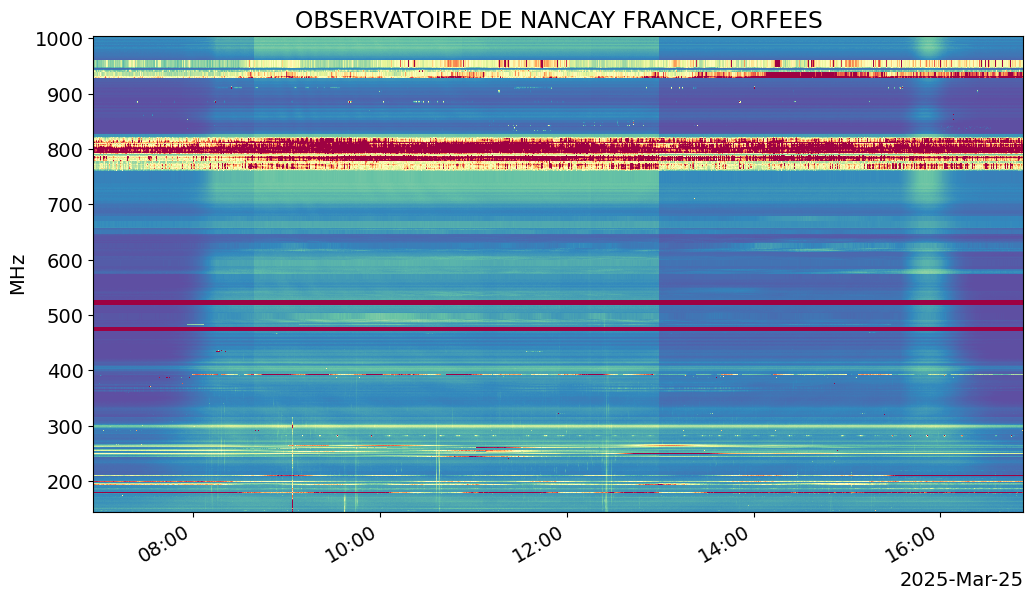

In [7]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
orfees_spec_i.plot(axes = ax, vmin=vmm[0], vmax=vmm[1], cmap = 'Spectral_r')
plt.show()